In [1]:
import math
import corner
import emcee
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import loggamma as lng
from scipy.optimize import minimize


mpl.rc('font', size=14)
mpl.rc('font', family='serif', serif='palatino')

In [2]:
#Height and particle number data
z = np.array([0,6,12,18])*1e-4
n = np.array([1880,940,530,305])

#Relevant constants
r= .52e-4 #cm
g = 980 #cm/s^2
d_rho=.063 #g/cm^3
T = 293 #Kelvin

#E/z
E = (4*np.pi*(r**3)*(d_rho)*g/3)


#negative log likelihood
def sumlnL(params):
    v0,kb = params
    totallnL = []
    for i in range(len(n)):
        loglike= n[i]*np.log(v0) -n[i]*(E*z[i]/(kb*T)) -v0*np.exp( -E*z[i]/(kb*T) ) -lng(n[i]+1)
        totallnL.append(-loglike)
    total = np.sum(totallnL)
    return total

def logprior(params):
    v,k = params
    if 500<v<2100 and 0 < k < 3e-16:
        return 0
    return -np.inf

def logprob(params):
    logpri = logprior(params)
    if not np.isfinite(logpri):
        return -np.inf
    return logpri - sumlnL(params)

#initial guesses
v0 = 500
kb = 1e-10
p0 = [v0,kb]

#minimizing and updating seed
res = minimize(sumlnL,p0,method = "Nelder-Mead")

In [3]:
vpos, kpos = res.x[0],res.x[1]
pos = np.zeros((32,2))

#seeding walkers with random values in neighborhood of best values
v_init = vpos+ 10*np.random.random(32)
k_init = kpos+ 1e-16*np.random.random(32)

pos[:,0] = v_init
pos[:,1] = k_init

nwalkers, ndim = 32,2

#actually running mcmc
sampler = emcee.EnsembleSampler(nwalkers,ndim,logprob)
sampler.run_mcmc(pos,5000,progress=True);

100%|██████████| 5000/5000 [00:15<00:00, 331.12it/s]


Text(0.5, 0, 'Steps')

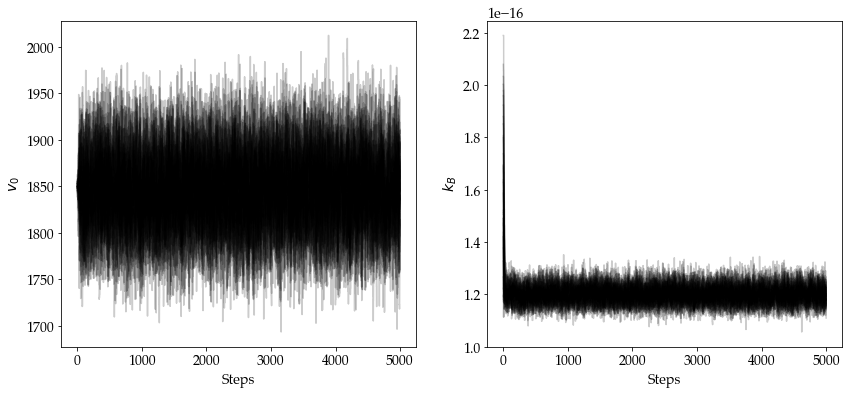

In [4]:
#Plotting MCMC chains
plt.figure(figsize=(14,6))

plt.subplot(121)
for i in range(0,32):
    plt.plot(sampler.chain[i][:,0], 'k', alpha=.2)
plt.ylabel('$v_0$')
plt.xlabel('Steps')

plt.subplot(122)
for i in range(0,32):
    plt.plot(sampler.chain[i][:,1], 'k', alpha=.2)
plt.ylabel('$k_B$')
plt.xlabel('Steps')


In [5]:
#PART B

In [6]:
tau = sampler.get_autocorr_time()
print("Autocorrelation times for [v, k]=",tau)

Autocorrelation times for [v, k]= [27.63306064 28.09185652]


In [7]:
flat_samples = sampler.get_chain(discard=int(4*tau[0]//1), thin=14, flat=True)

Text(0, 0.5, 'Autocorrelation')

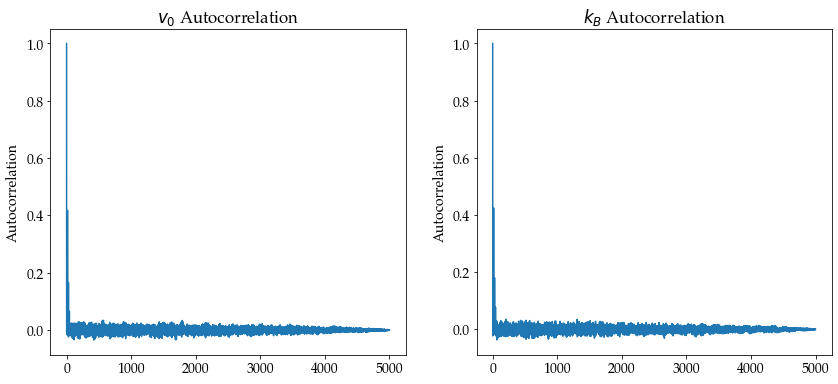

In [8]:
v_acor = emcee.autocorr.function_1d(flat_samples[:,0])
v_xs = np.linspace(0,5000,len(flat_samples[:,0]))

k_acor = emcee.autocorr.function_1d(flat_samples[:,1])
k_xs = np.linspace(0,5000,len(flat_samples[:,1]))

plt.figure(figsize=(14,6))

plt.subplot(121)
plt.plot(v_xs,v_acor)
plt.title('$v_0$ Autocorrelation')
plt.ylabel('Autocorrelation')

plt.subplot(122)
plt.plot(k_xs,k_acor)
plt.title('$k_B$ Autocorrelation')
plt.ylabel('Autocorrelation')


In [9]:
#PART C

There is a negative correlation between v0 and kB


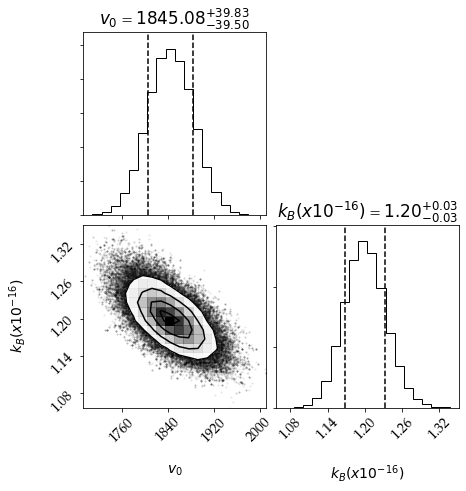

In [10]:
#reshaping chains, discarding burn in, and then rescaling kb to plot
allsamples = sampler.chain[:, int(4*tau[0]//1):, :].reshape((-1, ndim))
allsamples[:,1] = 1e16*allsamples[:,1]
fig = corner.corner(allsamples, labels=["$v_0$", "$k_B (x10^{-16})$"], quantiles = [.16,.84], show_titles=True)
fig.set_size_inches(7,7)
print('There is a negative correlation between v0 and kB')

In [11]:
#PART D

In [12]:
R = 8.32e7
kbest = 1.2e-16
klower = 1.17e-16
kupper = 1.23e-16
Nbest = R/kbest

print("68% CI for Avogadro's number is from",R/kupper,'to',R/klower,', with a \nbest estimate of',Nbest)

68% CI for Avogadro's number is from 6.764227642276423e+23 to 7.111111111111111e+23 , with a 
best estimate of 6.933333333333333e+23


In [13]:
#PART E

In [14]:
def logvprior(v):
    if 500<v<2100:
        return 0
    return -np.inf

def jefflogk(k):
    a = 1e-20
    if 0 < k < 3e-16:
        return np.log( (1/(a+k)*(1/np.log((a+3e-16)/(a)))) )
    return -np.inf

def jefflogprob(params):
    v,k = params
    logpri = jefflogk(k) + logvprior(v)
    if not np.isfinite(logpri):
        return -np.inf
    return logpri - sumlnL(params)

In [15]:
pos = np.zeros((32,2))

v_init = vpos+10*np.random.random(32)
k_init = kpos +1e-16*np.random.random(32)

pos[:,0] = v_init
pos[:,1] = k_init


jeffsampler = emcee.EnsembleSampler(nwalkers,ndim,jefflogprob)
jeffsampler.run_mcmc(pos,5000, progress=True);

100%|██████████| 5000/5000 [00:17<00:00, 291.60it/s]


Text(0.5, 0, 'Steps')

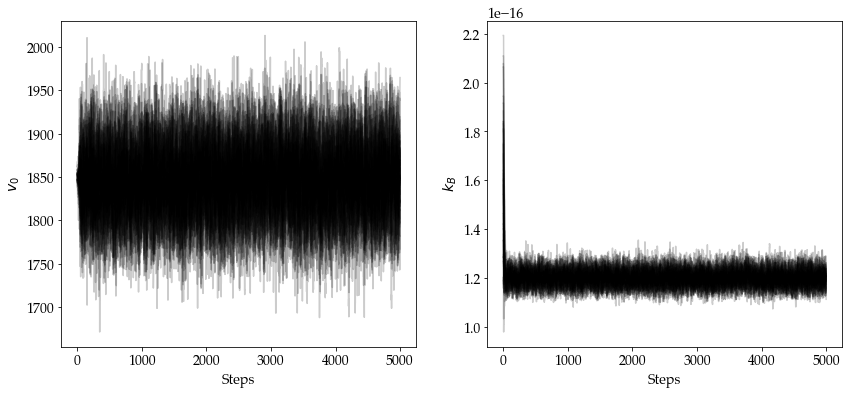

In [16]:
#Plotting MCMC chains
plt.figure(figsize=(14,6))

plt.subplot(121)
for i in range(0,32):
    plt.plot(jeffsampler.chain[i][:,0], 'k', alpha=.2)
plt.ylabel('$v_0$')
plt.xlabel('Steps')

plt.subplot(122)
for i in range(0,32):
    plt.plot(jeffsampler.chain[i][:,1], 'k', alpha=.2)
plt.ylabel('$k_B$')
plt.xlabel('Steps')

In [17]:
tau2 = jeffsampler.get_autocorr_time()
print("New autocorrelation times for [v, k]=",tau2)

New autocorrelation times for [v, k]= [32.95868581 30.43426295]


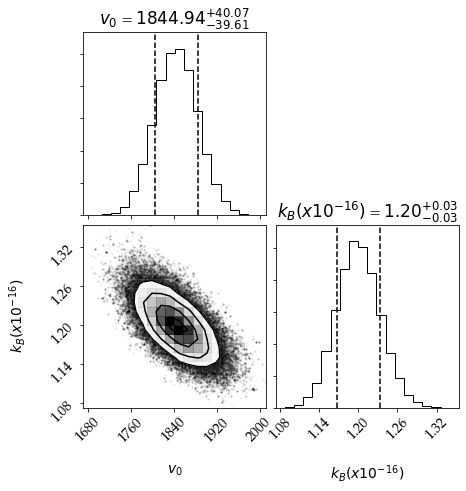

In [18]:
#reshaping chains, discarding burn in, and then rescaling kb to plot
allsamples2 = jeffsampler.chain[:, int(4*tau2[0]//1):, :].reshape((-1, ndim))
allsamples2[:,1] = 1e16*allsamples2[:,1]
fig = corner.corner(allsamples2, labels=["$v_0$", "$k_B (x10^{-16})$"], quantiles = [.16,.84], show_titles=True)
fig.set_size_inches(7,7)

In [20]:
Ntrue = 6.022e23
(Nbest-Ntrue)/Ntrue #percent difference between best estimate and CODATA values

0.15133399756448568

In [21]:
#PART F

#There is a 15.1% difference between my obtained best estimate and the current 
#CODATA value of 6.022e23/mol. This is more than a 5 sigma difference, and is therefore
#statistically significant. I can't think of any systematic errors off hand, other than 
#the fact that he took so few data points. With more data, we may have gotten a significantly
#better value. We also used a constant r value for the mastic particles, when in reality they
#may not have all been the same size. Since they are all the same density, this would change
#the values of gravitational potential energy that we plug in.